<div style="text-align: center;">
    <img src="logoucm.png" style="height: 250px;">
    <br/>
    <span style="color:#888"></span>
</div>





<font size="6"><center>***Metodos numéricos en finanzas***</center></font>

<font size="5"><center><span style="color:blue">***Nombre y Apellidos: Andrés Velasco Sánchez***</span></center></font>

## Importamos las librerías necesarias

In [341]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, log, exp, pi
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import t
import scipy.stats as si

In [342]:
m=2**(31)-1
a=16807
b=0

In [343]:

def generador_congruencial(semilla, m, a, b):
    x = semilla
    inv_m = 1 / m
    while True:
        x = (a * x + b) % m
        yield x * inv_m
def box_muller(N,ant=False):
    g_2 = generador_congruencial(123456789, m, a, b)
    n = N * 2
    U = [1 - next(g_2) if ant else next(g_2) for _ in range(n)]
    u1 = np.array(U[0::2])
    u2 = np.array(U[1::2])

    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(2.0 * np.pi * u2)
    return z0, z1


def marsaglia_method(N,ant=False):
    g_3 = generador_congruencial(123456789, m, a, b)
    X = []
    Y = []
    n = 0
    while n<N:
        U_1 = 1-next(g_3) if ant else next(g_3)
        U_2 = 1-next(g_3) if ant else next(g_3)
        v_1 = 2 * U_1 - 1
        v_2 = 2 * U_2 - 1
        R_2 = v_1**2 + v_2**2
        if R_2 >= 1:
            continue

        y = np.sqrt(-2 * np.log(R_2) / R_2)
        X.append(v_1 * y)
        Y.append(v_2 * y)
        n += 1

    return np.array(X), np.array(Y)

def brownian_motion(T, N,X,Y):
    dt = T / N
    X = [0]+X.tolist()
    Y = [0]+Y.tolist()
    X = np.cumsum(np.sqrt(dt) * np.array(X))
    Y = np.cumsum(np.sqrt(dt) * np.array(Y))
    return X, Y

import matplotlib.pyplot as plt
import seaborn as sns

def plot_variacion(df, eje_x, valores_eje, parametros_fijos, lineas_parametros, titulo_suptitle):

    
    fig, axes = plt.subplots(1, len(lineas_parametros), figsize=(6*len(lineas_parametros),5), sharey=True)
    if len(lineas_parametros) == 1:
        axes = [axes]
    
    palette = sns.color_palette("Set1", n_colors=3)
    
    for ax_idx, (param_name, valores_linea) in enumerate(lineas_parametros.items()):
        for i, val_linea in enumerate(valores_linea):
            color = palette[i % 3]
            V_call_vals = []
            V_put_vals = []
            
            for val_eje in valores_eje:
                # Construir tuplas para xs
                niveles = []
                for nivel in ['k','r','σ','T']:
                    if nivel == eje_x:
                        niveles.append(val_eje)
                    elif nivel == param_name:
                        niveles.append(val_linea)
                    else:
                        niveles.append(parametros_fijos.get(nivel, df.index.get_level_values(nivel)[0]))
                
                df_subset = df.xs(tuple(niveles), level=('k','r','σ','T'))
                V_call_vals.append(df_subset['V_call'].values[0])
                V_put_vals.append(df_subset['V_put'].values[0])
            
            ax = axes[ax_idx]
            ax.plot(valores_eje, V_call_vals, marker='o', color=color, label=f'Call {param_name}={val_linea}')
            ax.plot(valores_eje, V_put_vals, marker='s', linestyle='--', color=color, label=f'Put {param_name}={val_linea}')
            
        ax.set_xlabel(eje_x)
        ax.set_title(f"Variación con {param_name}")
        ax.grid(True)
        ax.legend(fontsize=8)
    
    axes[0].set_ylabel("Valor de la opción")
    plt.suptitle(titulo_suptitle, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
def calcular_estadisticas_montecarlo(valores):
    n_muestras = len(valores)
    media = np.mean(valores)
    varianza = np.var(valores, ddof=1)
    desviacion_std = np.std(valores, ddof=1)
    t_critico = t.ppf(0.975, df=n_muestras - 1)

    precision = t_critico * (desviacion_std / sqrt(n_muestras))

    return media, varianza, precision

def imprimir_tabla_estadisticas(df):
    print("\n" + "="*75)
    print("      RESULTADOS MONTE CARLO - OPCION CALL ASIATICA")
    print("="*75)
    print(f"{'Opción':<10} | {'Valor estimado':>15} | {'Varianza':>15} | {'Precisión (95%)':>18}")
    print("-"*75)

    for _, row in df.iterrows():
        print(f"{row['Opción']:<10} | "
              f"{row['Valor estimado']:>15.6f} | "
              f"{row['Varianza']:>15.6f} | "
              f"{row['Precisión (95%)']:>18.6f}")

    print("="*75 + "\n")

In [344]:
r = 0.03
r_c = log(1+r)
K = 14
T = 1
sigma = 0.3
S0 = 14
d_c = 0
d=0
N = 1000   


In [345]:
def black_scholes(S0, K, T, r, sigma, d_c):
    r_c = log(1+r)
    d1 = (np.log(S0/K) + (r_c - d_c + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    V_call = S0*si.norm.cdf(d1)-K*np.exp(-r_c*T)*si.norm.cdf(d2)
    V_put = K*np.exp(-r_c*T)*si.norm.cdf(-d2)-S0*si.norm.cdf(-d1)
    return V_call, V_put

V_call_1,V_put_1 = black_scholes(S0, K, T, r_c, sigma,d_c)

<font size="6"><center><span style="color:blue">***Práctica 4***</span></center></font>

<font size="4" color=blue>**Apartado a**</font>
***
Se trata de ver la influencia que tienen los parámetros en el valor de la opción, de acuerdo a la fórmula de Black-Scholes, de una forma intuitiva basada en revisar el cambio del valor de la opción cuando cambian los parámetros a través de una rejilla de valores. En la mayoría de los casos, se puede ver una cuantificación más exacta de forma analítica utilizando la derivada parcial del valor de la opción con respecto a la variable que estamos examinando.

Teniendo en cuenta la fórmula de Black-Scholes para valoración de opciones:  

$$
V_{\mathrm{call}}(S,t) = Se^{-d_c t} \Phi(d_1) - Ke^{-r_c t} \Phi(d_2),
$$

donde:
$$
d_1 = \frac{\ln(S/K) + (r_c -d_c + 0.5 \sigma^2)t}{\sigma \sqrt{t}}, \quad d_2 = d_1 -\sigma\sqrt{t}.
$$
***
**Recordatorio datos utilizados anteriormente:**
- $r = 0.03$
- Strike = $14$
- Plazo $T = 1,2,3$
- $\sigma = 0.3$
- $S_0 = 14$
- $d = 0$
    
<font size="2" color=grey>**Nota para comprobación:** $t=1; V_{\mathrm{call}}=1.856787;V_{\mathrm{put}}=1.449020$.</font>
***
Se trata de realizar una tabla en la que por filas se realicen modificaciones del valor del strike $K$, por ejemplo para valores 12, 13, 14, 15, 16 y por columnas de la tasa de interés $r$, por ejemplo valores 0.01, 0.02, 0.03, 0.04, 0.05 y el contenido de la celda se corresponda con el valor de la opción. Mostrar 2 tablas, la primera para T=0.5 y la segunda para T=1. Ejemplo de estilo de tabla:

<center><strong>Valores de distintas opciones de compra Call</strong></center>
   
|   |   |   | **r** |    |   |
|--------------|--------------|--------------|--------------|--------------|--------------|
| **k**    | **0.01**    | **0.02**    | **0.03**    | **0.04**    | **0.05**    |
| **12**    | ......    | ......    | ......    | ......    | ......    |
| **13**    | ......    | ......    | ......    | ......    | ......    |
| **14**    | ......    | ......    |1.856787| ......    | ......    |
| **15**    | ......    | ......    | ......    | ......    | ......    |
| **16**    | ......    | ......    | ......    | ......    | ......    |








In [346]:
r = [0.01,0.02,0.03,0.04,0.05]
k = [12,13,14,15,16]
T = [0.5,1,2,3]
sigmas = [0.1,0.2,0.3,0.4,0.5]

index = pd.MultiIndex.from_product(
    [r, k, T,sigmas],
    names=["r", "k", "T","σ"]
)


df = pd.DataFrame(index=index, columns=["V_call", "V_put"], dtype=float)
for (r, K, T,sigma) in df.index:
    V_call, V_put = black_scholes(S0, K, T, r, sigma, d_c)
    df.loc[(r, K, T,sigma), "V_call"] = V_call
    df.loc[(r, K, T,sigma), "V_put"] = V_put

### Tablas para T=0.5 y T=1
Las tablas las he sacado a partir de esta línea de código (cambiando los parámetros según las características de la tabla).
```python
tabla_call = (
    df.xs((1, 0.3), level=('T', 'σ'))   
    ['V_call']                      
    .unstack(level='r')              
)

```

<table style="font-size:12px; border-collapse: collapse;">
<tr>
<td style="vertical-align: top; padding-right: 20px;">

<b>Valores CALL (T=0.5, σ=0.3)</b><br>
<table style="font-size:12px; border-collapse: collapse;" border="1">
<tr>
<th>k \ r</th><th>0.01</th><th>0.02</th><th>0.03</th><th>0.04</th><th>0.05</th>
</tr>
<tr><td>12</td><td>2.418062</td><td>2.461715</td><td>2.505158</td><td>2.548382</td><td>2.591382</td></tr>
<tr><td>13</td><td>1.747686</td><td>1.786437</td><td>1.825176</td><td>1.863891</td><td>1.902572</td></tr>
<tr><td>14</td><td>1.214709</td><td>1.246999</td><td>1.279438</td><td>1.312015</td><td>1.344717</td></tr>
<tr><td>15</td><td>0.813874</td><td>0.839249</td><td>0.864872</td><td>0.890734</td><td>0.916824</td></tr>
<tr><td>16</td><td>0.527375</td><td>0.546293</td><td>0.565496</td><td>0.584977</td><td>0.604730</td></tr>
</table>

</td>
<td style="vertical-align: top; padding-left: 20px;">

<b>Valores PUT (T=0.5, σ=0.3)</b><br>
<table style="font-size:12px; border-collapse: collapse;" border="1">
<tr>
<th>k \ r</th><th>0.01</th><th>0.02</th><th>0.03</th><th>0.04</th><th>0.05</th>
</tr>
<tr><td>12</td><td>0.358508</td><td>0.343486</td><td>0.329109</td><td>0.315350</td><td>0.302182</td></tr>
<tr><td>13</td><td>0.683170</td><td>0.658355</td><td>0.634456</td><td>0.611440</td><td>0.589273</td></tr>
<tr><td>14</td><td>1.145229</td><td>1.109064</td><td>1.074048</td><td>1.040144</td><td>1.007318</td></tr>
<tr><td>15</td><td>1.739432</td><td>1.691462</td><td>1.644811</td><td>1.599444</td><td>1.555325</td></tr>
<tr><td>16</td><td>2.447970</td><td>2.388654</td><td>2.330765</td><td>2.274268</td><td>2.219131</td></tr>
</table>

</td>
</tr>
</table>


<table style="font-size:12px; border-collapse: collapse;">
<tr>
<td style="vertical-align: top; padding-right: 20px;">

<b>Valores CALL (T=1,σ=0.3)</b><br>
<table style="font-size:12px; border-collapse: collapse;" border="1">
<tr>
<th>k \ r</th><th>0.01</th><th>0.02</th><th>0.03</th><th>0.04</th><th>0.05</th>
</tr>
<tr><td>12</td><td>2.825326</td><td>2.902243</td><td>2.979025</td><td>3.055629</td><td>3.132018</td></tr>
<tr><td>13</td><td>2.228325</td><td>2.298773</td><td>2.369444</td><td>2.440294</td><td>2.511277</td></tr>
<tr><td>14</td><td>1.731245</td><td>1.793757</td><td><span style="color:red">1.856787</span></td><td>1.920289</td><td>1.984221</td></tr>
<tr><td>15</td><td>1.327261</td><td>1.381214</td><td>1.435891</td><td>1.491254</td><td>1.547265</td></tr>
<tr><td>16</td><td>1.005796</td><td>1.051255</td><td>1.097558</td><td>1.144674</td><td>1.192575</td></tr>
</table>

</td>
<td style="vertical-align: top; padding-left: 20px;">

<b>Valores PUT (T=1,σ=0.3)</b><br>
<table style="font-size:12px; border-collapse: collapse;" border="1">
<tr>
<th>k \ r</th><th>0.01</th><th>0.02</th><th>0.03</th><th>0.04</th><th>0.05</th>
</tr>
<tr><td>12</td><td>0.706514</td><td>0.666949</td><td>0.629510</td><td>0.594091</td><td>0.560590</td></tr>
<tr><td>13</td><td>1.099612</td><td>1.043871</td><td>0.990803</td><td>0.940294</td><td>0.892229</td></tr>
<tr><td>14</td><td>1.592631</td><td>1.519248</td><td>1.449020</td><td>1.381828</td><td>1.317554</td></tr>
<tr><td>15</td><td>2.178746</td><td>2.087096</td><td>1.998998</td><td>1.914331</td><td>1.832980</td></tr>
<tr><td>16</td><td>2.847381</td><td>2.737530</td><td>2.631538</td><td>2.529289</td><td>2.430670</td></tr>
</table>

</td>
</tr>
</table>


Se pide analizar y comentar los siguientes casos:

- **(a.1.) Modificaciones en el tiempo T hasta la fecha de ejercicio.**

Influencia del tiempo hasta vencimiento (T) en opciones

- **T = tiempo hasta vencimiento** de la opción.
- Aparece en:
  - **Descuentos exponenciales:**  (afectan el valor según dividendos y tasa libre de riesgo.)
    - CALL: $S e^{-d_c T}$  
    - PUT: $K e^{-r T}$  
  - **Factores d1 y d2:**  
    $d_1 = \frac{\ln(S/K) + (r_c - d_c + 0.5\sigma^2) T}{\sigma \sqrt{T}}, \quad
    d_2 = d_1 - \sigma \sqrt{T}$  




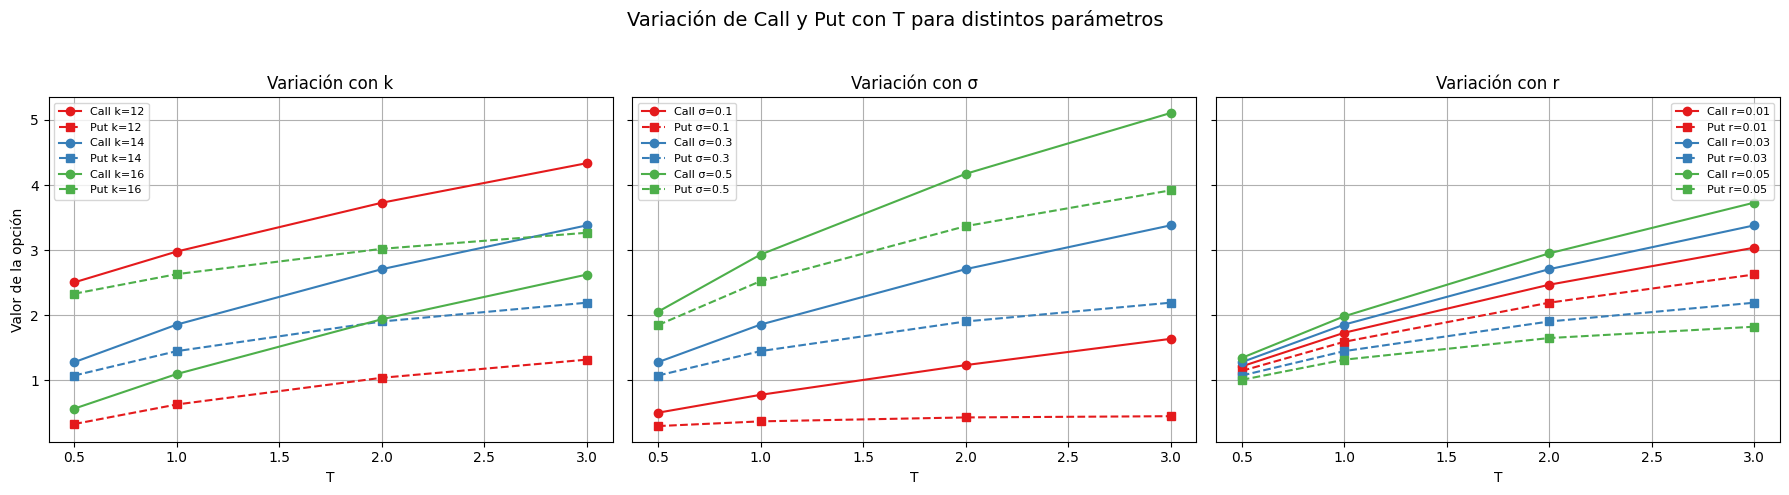

In [348]:

plot_variacion(
    df=df,
    eje_x='T',  
    valores_eje=[0.5, 1, 2, 3], 
    parametros_fijos={'k':14, 'r':0.03, 'σ':0.3}, 
    lineas_parametros={
        'k':[12,14,16],  
        'σ':[0.1,0.3,0.5],  
        'r':[0.01,0.03,0.05] 
    },
    titulo_suptitle="Variación de Call y Put con T para distintos parámetros"
)


**Efectos al aumentar T**:

En la gráfica de arriba hemos fijado como variables independiente la T, y hemos representado 3 gráficos en los cuales vamos modificando 1 variables mientars las dos se quedaan fijas, para observar el comportamiento con respecto al aumento de T. Como podemos observar las valoraciones de CALL y PUT en general aumentan.



- **(a.2.) Modificaciones en la tasa de interés r.**


Tipo de interés libre de riesgo (r)

- **Definición:** ${r}$ es la tasa de interés anualizada, compuesta de forma continua (también llamada fuerza del interés).

- **Aparece en la fórmula de Black-Scholes en varios lugares:**

1. **Descuento del strike** en el valor de la opción:

   - CALL: $V_{\mathrm{call}} = S e^{-d_c T} \Phi(d_1) - K e^{-r T} \Phi(d_2)$  
     → el término $K e^{-r T}$ muestra cómo r reduce el valor presente del strike.

   - PUT: $V_{\mathrm{put}} = K e^{-r T} \Phi(-d_2) - S e^{-d_c T} \Phi(-d_1)$  
     → r aparece también en el descuento del strike.

2. **Dentro de d1 y d2**, que calculan la probabilidad de terminar in the money:

   $$
   d_1 = \frac{\ln(S/K) + (r - d_c + 0.5\sigma^2) T}{\sigma \sqrt{T}}, \quad
   d_2 = d_1 - \sigma \sqrt{T}
   $$

   → r aparece sumando al crecimiento esperado del activo menos dividendos $d_c$, afectando la probabilidad de que la opción termine ITM ('in the money')




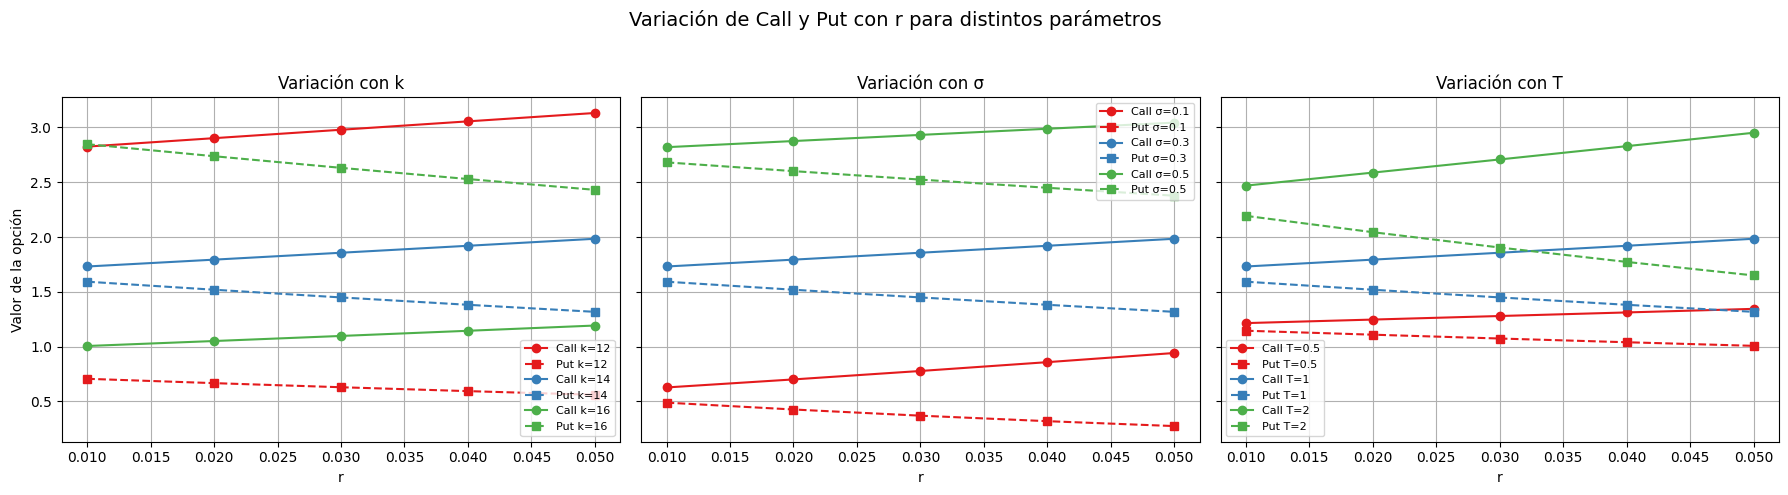

In [349]:
plot_variacion(
    df=df,
    eje_x='r',  
    valores_eje=[0.01, 0.02, 0.03, 0.04, 0.05],  # valores de r que quieres ver en el eje X
    parametros_fijos={'k':14, 'σ':0.3, 'T':1},    # fijas los demás parámetros
    lineas_parametros={
        'k':[12,14,16],   # líneas diferentes de K
        'σ':[0.1,0.3,0.5],# líneas diferentes de σ
        'T':[0.5,1,2]     # líneas diferentes de T
    },
    titulo_suptitle="Variación de Call y Put con r para distintos parámetros"
)


Podemos observar como aumentar r provoca el incremento del valor de la opción CALL, y a su vez, el decremento del valor de la opción PUT. Esto se debe en parte a que al aumentar r aumenta la tasa de descuento que se ejerce sobre el strike K.

- **(a.3.) Modificaciones en el precio de ejercicio K.**


### Precio de ejercicio (K)

- **Definición:**  
  ${K}$ es el **precio de ejercicio o strike** de la opción.  
  Representa el precio al que el titular de la opción puede **comprar (Call)** o **vender (Put)** el activo subyacente al vencimiento.

- **Influencia en Black-Scholes:**

1. **Valor de la opción:**

   - Call: $V_{\mathrm{call}} = S e^{-d_c T} \Phi(d_1) - K e^{-r T} \Phi(d_2)$  
   - Put:  $V_{\mathrm{put}} = K e^{-r T} \Phi(-d_2) - S e^{-d_c T} \Phi(-d_1)$  

   → K aparece descontado en el término de strike futuro .

2. **En d1 y d2:**

   $$
   d_1 = \frac{\ln(S/K) + (r - d_c + 0.5\sigma^2) T}{\sigma \sqrt{T}}, \quad
   d_2 = d_1 - \sigma \sqrt{T}
   $$

   → K afecta la probabilidad de que la opción termine **in the money**.



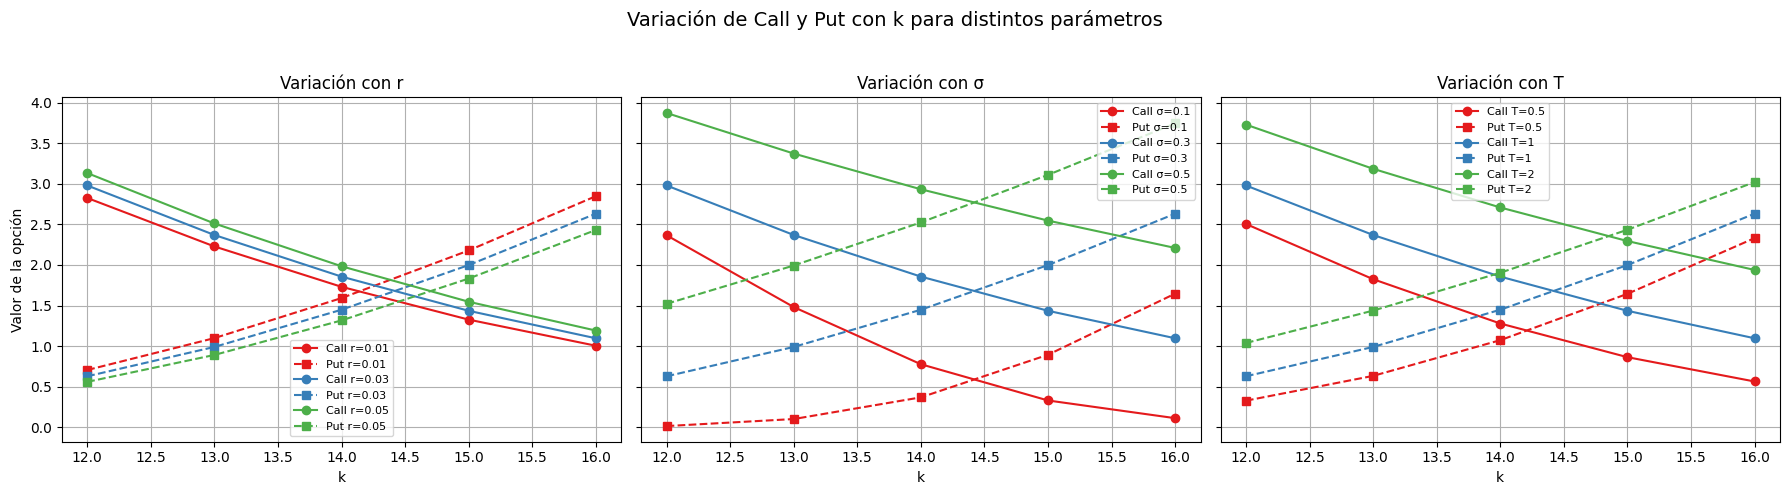

In [350]:
plot_variacion(
    df=df,
    eje_x='k',  
    valores_eje=[12, 13,14, 15,16],  # valores de r que quieres ver en el eje X
    parametros_fijos={'r':0.03, 'σ':0.3, 'T':1},    # fijas los demás parámetros
    lineas_parametros={
        'r':[0.01,0.03,0.05] ,   # líneas diferentes de K
        'σ':[0.1,0.3,0.5],# líneas diferentes de σ
        'T':[0.5,1,2]     # líneas diferentes de T
    },
    titulo_suptitle="Variación de Call y Put con k para distintos parámetros"
)


Efectos de K en el valor de la opción

- Al **aumentar K** (precio de ejercicio / strike):

  - **Call:** el valor **disminuye**.  
    - Intuición: comprar el activo al strike más alto es menos atractivo.
  
  - **Put:** el valor **aumenta**.  
    - Intuición: vender el activo al strike más alto es más beneficioso.

- Esto se observa tanto en las **gráficas** como en la **fórmula de Black-Scholes**



- **(a.4.) Cambios en la volatilidad $\sigma$.**



**Definición:**  
  ${\sigma}$ es la **desviación estándar de los rendimientos logarítmicos** del activo subyacente.  
  Representa la **volatilidad** del precio de la acción, es decir, cuánto varía su precio en el tiempo.

**Influencia en Black-Scholes:**

1. **Valor de la opción:**

   - Call: $V_{\mathrm{call}} = S e^{-d_c T} \Phi(d_1) - K e^{-r T} \Phi(d_2)$  
   - Put:  $V_{\mathrm{put}} = K e^{-r T} \Phi(-d_2) - S e^{-d_c T} \Phi(-d_1)$  

   → ${\sigma}$ aparece en $d_1$ y $d_2$:
   $$
   d_1 = \frac{\ln(S/K) + (r - d_c + 0.5\sigma^2) T}{\sigma \sqrt{T}}, \quad
   d_2 = d_1 - \sigma \sqrt{T}
   $$



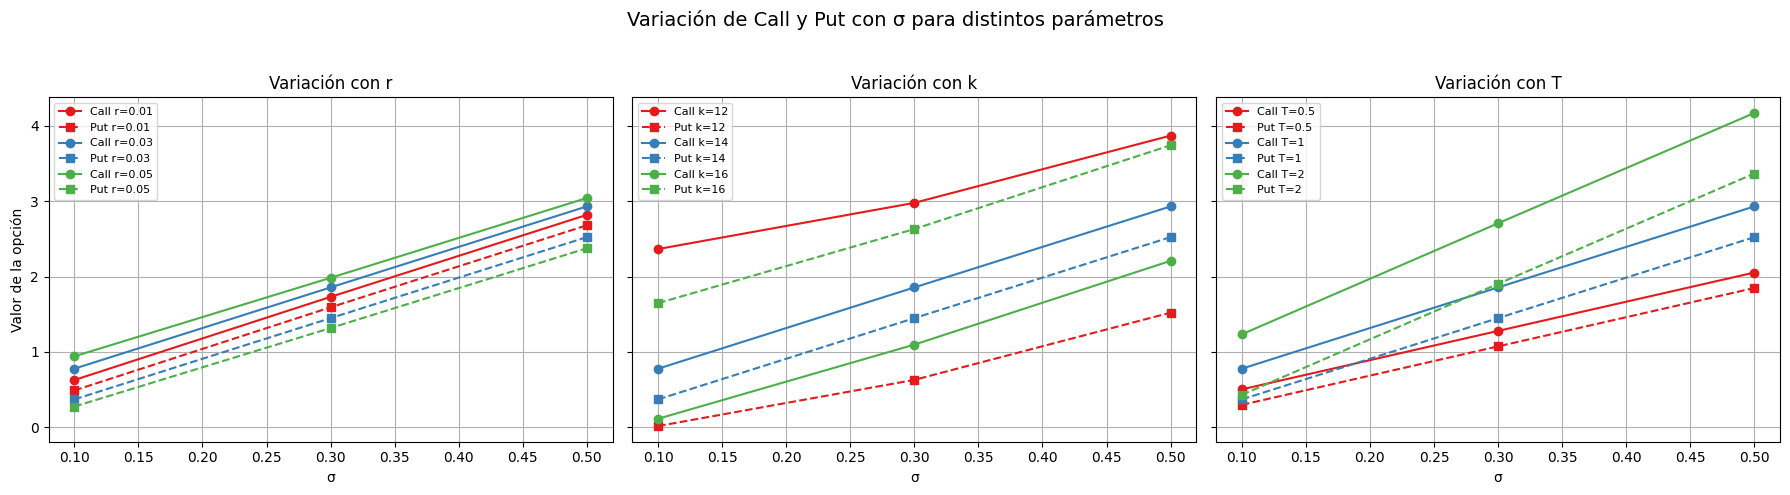

In [351]:
plot_variacion(
    df=df,
    eje_x='σ',  
    valores_eje=[0.1, 0.3, 0.5],  # valores de r que quieres ver en el eje X
    parametros_fijos={'r':0.03, 'k':14, 'T':1},    # fijas los demás parámetros
    lineas_parametros={
        'r':[0.01,0.03,0.05] ,   # líneas diferentes de K
        'k':[12,14,16],# líneas diferentes de σ
        'T':[0.5,1,2]     # líneas diferentes de T
    },
    titulo_suptitle="Variación de Call y Put con σ para distintos parámetros"
)


Efectos de σ en el valor de la opción

- **Call y Put aumentan con σ:**  
  En las gráficas de arriba, al movernos hacia la derecha (σ mayor), tanto el valor de las opciones **Call** como **Put** suben.  


- **Concordancia con Black-Scholes:**  
  - En la fórmula, σ aparece en $d_1$ y $d_2$:
    $$
    d_1 = \frac{\ln(S/K) + (r - d + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad
    d_2 = d_1 - \sigma\sqrt{T}
    $$
  - Gráficamente vemos que un σ mayor desplaza $d_1$ y $d_2$, aumentando $\Phi(d_1)$ y $1-\Phi(d_2)$ → incrementa el valor de Call y Put.


<font size="4" color=blue>**Apartado b**</font>
***
Obtener mediante simulación el valor de una opción call asiática browniana con dividendos y vencimiento T. Dar la estimación del valor y la precisión. Utilizar los mismos datos que en la práctica anterior y comparar el resultado con los resultados obtenidos en esa práctica.

<font size="2" color=grey>**Nota para comprobación:** $t=1; V_{\mathrm{call}}=1.213168;Varianza=3.244590;Precisión=0.111778$.</font>

In [352]:
r = 0.03
K = 14
T = 1
sigma = 0.3
S0 = 14
d=0
N = 1000   
k= 14
dt= 1/12

In [356]:

def ecuacion_estocastica(S0, r, d, sigma, T,Z_n, dt=1/12, N_caminos=100):
    M = int(T / dt)  
    Z_n = Z_n.reshape(N_caminos, M)
    multipliers=(1+r-d)**dt+sigma*np.sqrt(dt)*Z_n

    ST= S0*np.cumprod(multipliers, axis=1)

    return ST




Z0, Z1 = box_muller(N * 12)  
S_T = ecuacion_estocastica(S0, r, d_c, sigma, 1, Z1,N_caminos=N)
A = S_T.mean(axis=1) 
V_call_vals = exp(-r_c*(1)) * np.maximum(A-K, 0)
V_put_vals = exp(-r_c*(1)) * np.maximum(K-A, 0)



In [357]:
media_call, var_call, prec_call = calcular_estadisticas_montecarlo(V_call_vals)
media_put,  var_put,  prec_put  = calcular_estadisticas_montecarlo(V_put_vals)


tabla_resultados = pd.DataFrame([
    {
        "Opción": "Call",
        "Valor estimado": media_call,
        "Varianza": var_call,
        "Precisión (95%)": prec_call
    },
    {
        "Opción": "Put",
        "Valor estimado": media_put,
        "Varianza": var_put,
        "Precisión (95%)": prec_put
    }
])

imprimir_tabla_estadisticas(tabla_resultados)


      RESULTADOS MONTE CARLO - OPCION CALL ASIATICA
Opción     |  Valor estimado |        Varianza |    Precisión (95%)
---------------------------------------------------------------------------
Call       |        1.213168 |        3.244590 |           0.111778
Put        |        0.835457 |        1.427482 |           0.074141



In [355]:
assert f"{media_call:.6f}"== '1.213168'
assert f"{var_call:.6f}"== '3.244590'
assert f"{prec_call:.6f}"== '0.111778'


### Comparación Monte Carlo: Opciones Europeas vs Asiáticas

#### Valores estimados

| Opción           | Valor estimado |
|------------------|----------------|
| Call europea      | 2.0057         |
| Put europea       | 1.3930         |
| Call asiática     | 1.2132         |
| Put asiática      | 0.8355         |

**Observaciones:**
- Las opciones **asiáticas** dependen del precio promedio del subyacente.
- Esto reduce el valor esperado:  
  - $V_{\text{call asiática}} < V_{\text{call europea}}$  
  - $V_{\text{put asiática}} < V_{\text{put europea}}$
- La put asiática también es menos volátil que la europea.

#### Varianza y Precisión (95%)

| Opción           | Varianza       | Precisión (95%) |
|------------------|----------------|----------------|
| Call europea      | 10.0204        | 0.1964         |
| Put europea       | 3.6161         | 0.1180         |
| Call asiática     | 3.2446         | 0.1118         |
| Put asiática      | 1.4275         | 0.0741         |

**Observaciones:**
- Las opciones asiáticas tienen **menor varianza**, por lo que la estimación Monte Carlo es más estable.
- La menor varianza se traduce en **mayor precisión relativa**.

#### Conclusión

- El **promedio de precios** suaviza movimientos extremos del subyacente, reduciendo tanto el valor esperado como la varianza de la opción.
- Tanto **call como put asiáticas** son menos valiosas y más estables que sus equivalentes europeas.
